# Shallow regression for vector data

This script reads zip code data produced by **vectorDataPreparations** and creates a machine learning model for
predicting the average zip code income from population and spatial variables.

It assess the model accuracy with a test dataset but also predicts the number to all zip codes and writes it to a geopackage
for closer inspection

# 1. Read the data

In [1]:
import time
import geopandas as gpd
import pandas as pd
from math import sqrt
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor,ExtraTreesRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

### 1.1 Input and output file paths 

In [2]:

paavo_data = "../data/paavo"

### Relative path to the zip code geopackage file that was prepared by vectorDataPreparations.py
input_geopackage_path = os.path.join(paavo_data,"zip_code_data_after_preparation.gpkg")

### Output file. You can change the name to identify different regression models
output_geopackage_path = os.path.join(paavo_data,"median_income_per_zipcode_shallow_model.gpkg")

### 1.2 Read the input data to a Geopandas dataframe

In [3]:
original_gdf = gpd.read_file(input_geopackage_path)
original_gdf.head()

,postinumer,nimi,hr_mtu,euref_x,euref_y,pinta_ala,he_vakiy,he_naiset,he_miehet,he_kika,...,Pirkanmaa,Pohjanmaa,Pohjois-Karjala,Pohjois-Pohjanmaa,Pohjois-Savo,Päijät-Häme,Satakunta,Uusimaa,Varsinais-Suomi,geometry
0,00100,Helsinki Keskusta - Etu-Töölö,27577.0,-0.199953,-1.168668,-0.409187,5.500395,5.625018,5.353739,-0.831997,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((385653.893 6671591.048, 385573..."
1,00120,Punavuori,27523.0,-0.195383,-1.173029,-0.416345,1.761951,1.820420,1.694929,-0.999903,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((385316.092 6671076.984, 385279..."
2,00130,Kaartinkaupunki,30479.0,-0.189480,-1.172841,-0.416290,-0.108930,-0.097516,-0.121027,-0.831997,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((386212.111 6671061.262, 386176..."
3,00140,Kaivopuisto - Ullanlinna,29439.0,-0.188239,-1.176172,-0.414434,2.014145,2.166351,1.845281,-0.831997,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((386577.050 6670280.544, 386552..."
4,00150,Eira - Hernesaari,26546.0,-0.197130,-1.178021,-0.412826,2.499950,2.629719,2.354273,-0.999903,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((384846.102 6669565.816, 384823..."


# 2. Train the model 

You can try different regressor models by uncommenting the corresponding lines. You can also try different modeling parameters. 

Which one is the best model? Can you figure out how to improve it even more?

In [4]:
### Split the gdf to x (the predictor attributes) and y (the attribute to be predicted)
y = original_gdf['hr_mtu'] # Average income
### remove geometry and textual fields
x = original_gdf.drop(['geometry','postinumer','nimi','hr_mtu'],axis=1)

### Split the both datasets to train (80%) and test (20%) datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4, random_state=42)

### Choose the model to be used
model = GradientBoostingRegressor(n_estimators=30, learning_rate=0.1,verbose=1)
#model = RandomForestRegressor(n_estimators=30,verbose=1)
#model = BaggingRegressor(n_estimators=30,verbose=1)
#model = ExtraTreesRegressor(n_estimators=30,verbose=1)
#model = AdaBoostRegressor(n_estimators=30)

print(model)

### Train the model with x and y of the train dataset
model.fit(x_train, y_train)

### Predict the unemployed number to the test dataset
prediction = model.predict(x_test)

### Assess the accuracy of the model with root mean squared error, mean absolute error and coefficient of determination r2
rmse = sqrt(mean_squared_error(y_test, prediction))
mae = mean_absolute_error(y_test, prediction)
r2 = r2_score(y_test, prediction)

print(f"\nMODEL ACCURACY METRICS WITH TEST DATASET: \n" +
      f"\t Root mean squared error: {round(rmse)} \n" +
      f"\t Mean absolute error: {round(mae)} \n" +
      f"\t Coefficient of determination: {round(r2,4)} \n")


GradientBoostingRegressor(n_estimators=30, verbose=1)
      Iter       Train Loss   Remaining Time 
         1     8836419.2154            1.46s
         2     7663556.0673            1.14s
         3     6675021.5628            1.03s
         4     5859428.3510            0.93s
         5     5164052.0696            0.87s
         6     4584845.3509            0.86s
         7     4095677.4197            0.83s
         8     3676549.9127            0.79s
         9     3316849.4582            0.74s
        10     3016692.8723            0.71s
        20     1582189.5698            0.41s
        30     1172508.7238            0.00s

MODEL ACCURACY METRICS WITH TEST DATASET: 
	 Root mean squared error: 1208 
	 Mean absolute error: 889 
	 Coefficient of determination: 0.8459 



# 3. Predict average income to all zip codes

Here we take the model ran the last time in the previous cell and apply it to the whole dataset

In [5]:
### Drop the not-used columns from original_gdf as done before model training.
x = original_gdf.drop(['geometry','postinumer','nimi','hr_mtu'],axis=1)

### Predict the median income with already trained model
prediction = model.predict(x)

### Join the predictions to the original geodataframe and pick only interesting columns for results
original_gdf['predicted_hr_mtu'] = prediction.round(0)
original_gdf['difference'] = original_gdf['predicted_hr_mtu'] - original_gdf['hr_mtu']
resulting_gdf = original_gdf[['postinumer','nimi','hr_mtu','predicted_hr_mtu','difference','geometry']]

<AxesSubplot:title={'center':'Predicted average income by zip code'}>

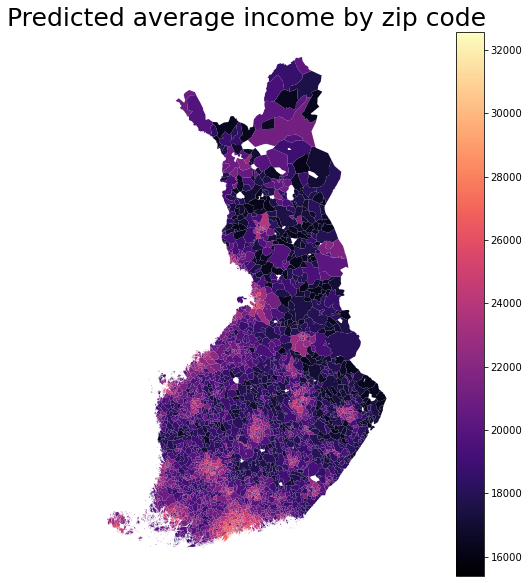

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Predicted average income by zip code", fontsize=25)
ax.set_axis_off()
resulting_gdf.plot(column='predicted_hr_mtu', ax=ax, legend=True, cmap="magma")

# 4. EXERCISE: Calculate the difference between real and predicted incomes

Calculate the difference of real and predicted income amounts by zip code level and plot a map of it

* **original_gdf** is the original dataframe
* **resulting_gdf** is the predicted one

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:title={'center':'Difference in average income by zip code'}>

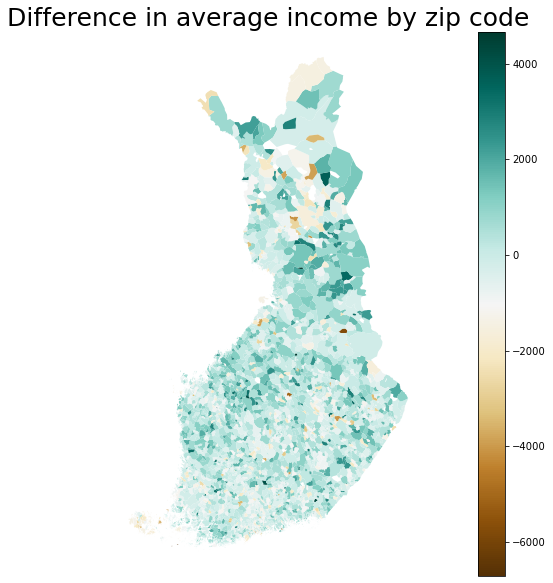

In [7]:
#### This is what students might do here
resulting_gdf['diff'] = resulting_gdf['predicted_hr_mtu'] - resulting_gdf['hr_mtu']
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Difference in average income by zip code", fontsize=25)
ax.set_axis_off()
resulting_gdf.plot(column='diff', ax=ax, legend=True, cmap="BrBG")